In [1]:
import torch


# Check PyTorch GPU
print("PyTorch:")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")




# ADD THESE 2 LINES AT THE VERY TOP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


#just add .to(device) 

PyTorch:
CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce MX130
Using device: cuda


/home/aliqnbri/.conda/envs/quera-project/lib/python3.11/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce MX130 which is of cuda capability 5.0.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/aliqnbri/.conda/envs/quera-project/lib/python3.11/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/aliqnbri/.conda/envs/quera-project/lib/python3.11/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce MX130 with CUDA capability sm_50 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce MX130 GPU with PyTorch

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
import pyproj
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
clean_df = pd.read_csv('../DataSets/clean_divar_data.csv')
raw_df = pd.read_csv('../DataSets/Divar.csv', usecols=['location_latitude','location_longitude'])

FileNotFoundError: [Errno 2] No such file or directory: 'clean_divar_data.csv'

In [4]:
clean_df['location_latitude'] = raw_df['location_latitude']
clean_df['location_longitude'] = raw_df['location_longitude']


In [6]:

# Remove rows with invalid geographic coordinates (global bounds)
valid_geo_mask = (
    clean_df['location_latitude'].between(-90, 90) & 
    clean_df['location_longitude'].between(-180, 180)
)
df = clean_df[valid_geo_mask].copy()
print(f"Remaining rows after geographic filtering: {len(df)}")

Remaining rows after geographic filtering: 655608



# =====================================================
# PART 1: Feature Selection and Initial Analysis
# =====================================================

In [7]:
# Only numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df[numerical_features].corr().abs()

# Select the upper triangle (no duplicate pairs)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find top 15 highest correlations
top_corr = upper_triangle.stack().sort_values(ascending=False).head(15)
print("Top 15 highly correlated feature pairs:\n")
print(top_corr)

# Optional: visualize as a heatmap
top_features = list(set([i for pair in top_corr.index for i in pair]))  # unique features from top pairs





Top 15 highly correlated feature pairs:

transformed_credit          transformed_credit_log               0.841922
rent_mode                   price_mode                           0.819376
building_to_land_ratio      building_size_transformed            0.816034
land_size                   unused_land                          0.815260
transformable_price         transformable_price_per_sqm          0.783874
total_floors_count          total_floors_count_transformed       0.775387
credit_value_log            transformable_credit_log             0.773962
has_parking                 comfort_score                        0.754902
floor                       floor_ratio                          0.751240
credit_value                transformed_credit_log               0.746018
extra_person_capacity       extra_person_capacity_transformed    0.740458
credit_value                credit_value_log                     0.739847
user_type                   has_water                            0.7277

In [30]:
top_features

['has_parking',
 'floor_ratio',
 'is_middle_floor',
 'rent_mode',
 'total_floors_count_transformed',
 'rent_price_at_weekends',
 'land_size',
 'extra_person_capacity_transformed',
 'transformable_price_per_sqm',
 'floor',
 'credit_value',
 'total_floors_count',
 'rent_price_on_special_days',
 'transformable_credit_log',
 'extra_person_capacity',
 'building_size_transformed',
 'has_water',
 'is_top_floor',
 'transformed_credit',
 'comfort_score',
 'credit_value_log',
 'transformed_credit_log',
 'transformable_price',
 'user_type',
 'building_to_land_ratio',
 'price_mode',
 'unused_land']

In [12]:
clustering_features = [
    'transformable_price',        # Price (most important for users)
    'building_size',             # Size of property
    'rooms_count',               # Number of rooms
    'building_age',              # Age of building
    'floor',                    # Floor number
    'total_floors_count',       # Total floors in building
    'has_elevator',             # Important amenity
    'has_parking',              # Important amenity
    'has_balcony',              # Nice-to-have feature
    'has_warehouse',            # Storage space
    'location_latitude',        # Geographic location
    'location_longitude'        # Geographic location
]

# Create clustering dataframe with selected features
df_clustering = clean_df[clustering_features].copy()

# Remove rows with missing values in key features
df_clustering = df_clustering.dropna()

# =====================================================
# PART 2: Convert Geographic Coordinates to UTM
# =====================================================

In [13]:

# Set up UTM projection for Iran (Zone 39N covers most of Iran)
transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:32639', always_xy=True)

utm_coords = []
for idx, row in df_clustering.iterrows():
    try:
        # Transform longitude, latitude to UTM x, y
        x, y = transformer.transform(row['location_longitude'], row['location_latitude'])
        utm_coords.append([x, y])
    except Exception as e:
        # In case of transformation error, use NaN
        utm_coords.append([np.nan, np.nan])

# Convert to numpy array and add to dataframe
utm_coords = np.array(utm_coords)
df_clustering['utm_x'] = utm_coords[:, 0]
df_clustering['utm_y'] = utm_coords[:, 1]

# Remove rows with invalid UTM coordinates
df_clustering = df_clustering.dropna(subset=['utm_x', 'utm_y'])

# Remove original lat/lon columns for clustering (we'll use UTM instead)
df_clustering = df_clustering.drop(['location_latitude', 'location_longitude'], axis=1)

print(f"Dataset shape after UTM conversion: {df_clustering.shape}")

Dataset shape after UTM conversion: (655608, 12)


In [14]:
# Remove rows with invalid UTM coordinates
df_clustering = df_clustering.dropna(subset=['utm_x', 'utm_y'])

print(f"Dataset shape after UTM conversion: {df_clustering.shape}")


Dataset shape after UTM conversion: (655608, 12)


# =====================================================
# PART 3: K-Means with 10 Clusters (Initial Analysis)
# =====================================================


In [16]:

# Prepare features for clustering (excluding original lat/lon)
# features_for_kmeans = df_clustering.drop(['location_latitude', 'location_longitude'], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Apply K-means with 10 clusters
kmeans_10 = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters_10 = kmeans_10.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustering['cluster_10'] = clusters_10

<Figure size 1500x1000 with 0 Axes>

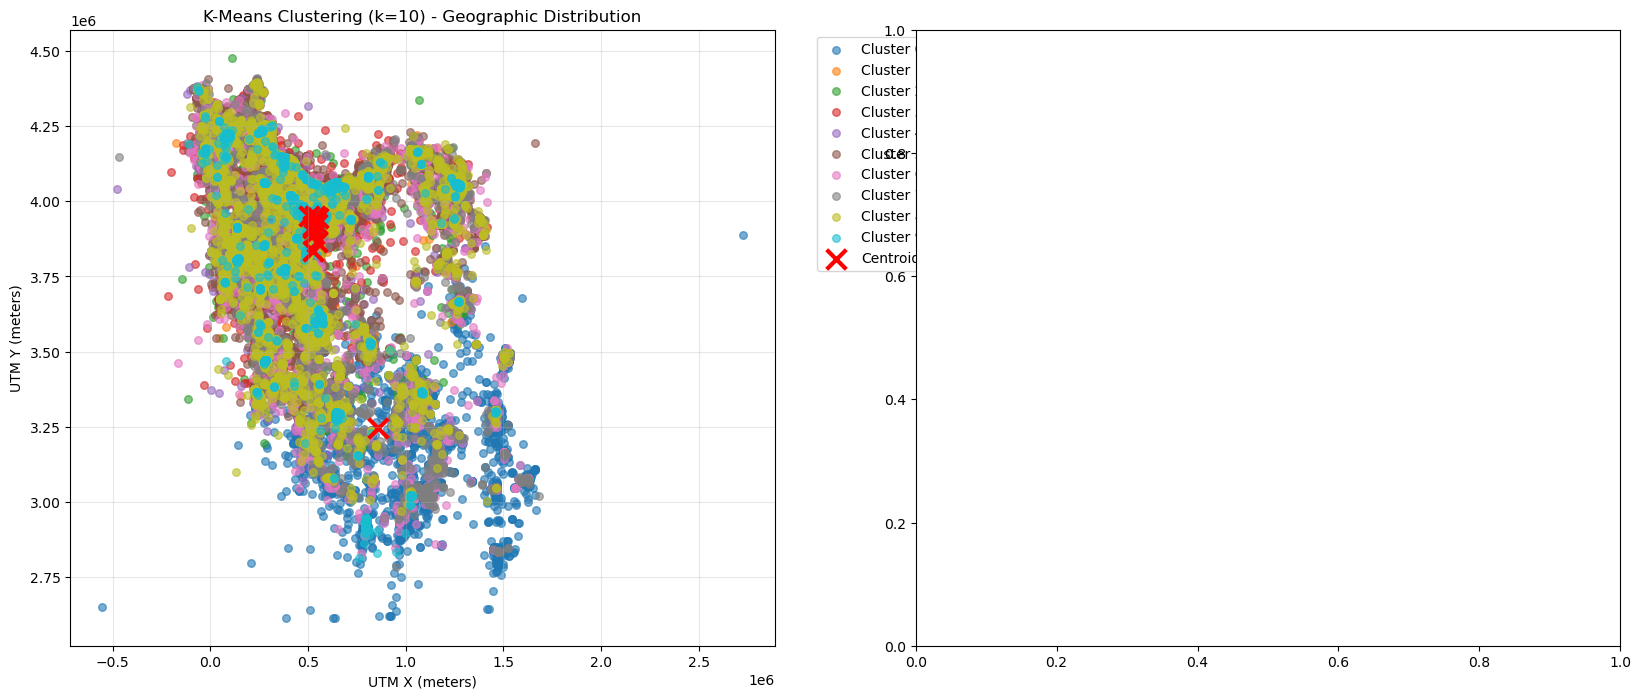

In [18]:
# Create scatter plot for price vs UTM coordinates
plt.figure(figsize=(15, 10))

# Create subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: UTM coordinates colored by cluster
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax1.scatter(cluster_data['utm_x'], cluster_data['utm_y'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)

# Plot cluster centers in UTM space
utm_x_idx = list(df_clustering.columns).index('utm_x')
utm_y_idx = list(df_clustering.columns).index('utm_y')
centers_utm_x = scaler.inverse_transform(kmeans_10.cluster_centers_)[:, utm_x_idx]
centers_utm_y = scaler.inverse_transform(kmeans_10.cluster_centers_)[:, utm_y_idx]

ax1.scatter(centers_utm_x, centers_utm_y, c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax1.set_xlabel('UTM X (meters)')
ax1.set_ylabel('UTM Y (meters)')
ax1.set_title('K-Means Clustering (k=10) - Geographic Distribution')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

In [19]:
# Plot 2: Price vs UTM X coordinate colored by cluster
price_idx = list(df_clustering.columns).index('transformable_price')
centers_price = scaler.inverse_transform(kmeans_10.cluster_centers_)[:, price_idx]

for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    ax2.scatter(cluster_data['utm_x'], cluster_data['transformable_price'], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)

ax2.scatter(centers_utm_x, centers_price, c='red', marker='x', s=200, linewidths=3, label='Centroids')
ax2.set_xlabel('UTM X (meters)')
ax2.set_ylabel('Transformable Price')
ax2.set_title('K-Means Clustering (k=10) - Price vs Location')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# =====================================================
# PART 4: Optimal K Selection with Multiple Methods
# =====================================================


In [ ]:
# Test k values from 1 to 20


In [ ]:


k_range = range(1, 21)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
distortions = []

print("Computing metrics for different k values...")
for k in k_range:
    if k == 1:
        wcss.append(np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2))
        silhouette_scores.append(0)
        distortions.append(np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2))
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    print(f"k={k} completed")

Computing metrics for different k values...
k=1 completed


KeyboardInterrupt: 

In [ ]:
# Plot the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Elbow Method
ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Calculate the rate of change to find elbow
wcss_diff = np.diff(wcss)
wcss_diff2 = np.diff(wcss_diff)
ax2.plot(range(2, len(wcss_diff2)+2), wcss_diff2, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Second Derivative of WCSS')
ax2.set_title('Second Derivative Method')
ax2.grid(True)

# Silhouette Analysis
ax3.plot(k_range[1:], silhouette_scores[1:], 'go-')  # Skip k=1
ax3.set_xlabel('Number of clusters (k)')
ax3.set_ylabel('Silhouette Score')
ax3.set_title('Silhouette Analysis')
ax3.grid(True)

In [ ]:
# Gap Statistic (simplified version)
# Generate random data with same dimensions for comparison
np.random.seed(42)
random_data = np.random.uniform(X_scaled.min(), X_scaled.max(), X_scaled.shape)
wcss_random = []

for k in k_range:
    if k == 1:
        wcss_random.append(np.sum((random_data - random_data.mean(axis=0)) ** 2))
    else:
        kmeans_random = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_random.fit(random_data)
        wcss_random.append(kmeans_random.inertia_)

gap_stats = np.log(wcss_random) - np.log(wcss)
ax4.plot(k_range, gap_stats, 'mo-')
ax4.set_xlabel('Number of clusters (k)')
ax4.set_ylabel('Gap Statistic')
ax4.set_title('Gap Statistic Method')
ax4.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

# Find optimal k using different methods
optimal_k_silhouette = k_range[1:][np.argmax(silhouette_scores[1:])] + 1  # +1 because we skip k=1
optimal_k_gap = k_range[np.argmax(gap_stats)]

In [ ]:

# Elbow method - find the point with maximum curvature
if len(wcss_diff2) > 0:
    optimal_k_elbow = np.argmax(wcss_diff2) + 2  # +2 because of double diff
else:
    optimal_k_elbow = 3

In [ ]:

print(f"\nOptimal k suggestions:")
print(f"Silhouette method: k = {optimal_k_silhouette}")
print(f"Gap statistic method: k = {optimal_k_gap}")
print(f"Elbow method (curvature): k = {optimal_k_elbow}")


In [ ]:

# Select the most frequent suggestion or use domain knowledge
suggested_ks = [optimal_k_silhouette, optimal_k_gap, optimal_k_elbow]
optimal_k = max(set(suggested_ks), key=suggested_ks.count)
print(f"\nSelected optimal k: {optimal_k}")

# =====================================================
# PART 5: DBSCAN Clustering
# =====================================================


In [ ]:
#Use only UTM coordinates and transformable price for DBSCAN
dbscan_features = df_clustering[['utm_x', 'utm_y', 'transformable_price']].copy()

# Standardize features for DBSCAN
scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(dbscan_features)


In [ ]:

# Grid search for optimal DBSCAN parameters to get 3 meaningful clusters
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = range(5, 50, 5)

best_score = -1
best_params = {'eps': 0.5, 'min_samples': 10}
best_n_clusters = 0

In [ ]:
print("Grid search for optimal DBSCAN parameters...")
print("Looking for parameters that produce exactly 3 clusters...")

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_dbscan_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # We want exactly 3 clusters with reasonable noise level
        if n_clusters == 3 and n_noise < len(labels) * 0.3:  # Less than 30% noise
            try:
                score = silhouette_score(X_dbscan_scaled, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_n_clusters = n_clusters
                    print(f"Better params found: eps={eps:.1f}, min_samples={min_samples}, "
                          f"clusters={n_clusters}, noise={n_noise}, silhouette={score:.3f}")
            except:
                continue

print(f"\nBest DBSCAN parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Best silhouette score: {best_score:.3f}")


In [ ]:

# Apply DBSCAN with best parameters
dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = dbscan_final.fit_predict(X_dbscan_scaled)

# Add DBSCAN labels to dataframe
df_clustering['dbscan_cluster'] = dbscan_labels


In [ ]:
#Count clusters and noise points
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

In [ ]:
# Visualize DBSCAN results
plt.figure(figsize=(20, 8))

# Plot 1: UTM coordinates
ax1 = plt.subplot(1, 2, 1)
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points in black
        col = [0, 0, 0, 1]
        marker = 'x'
        label = 'Noise'
        size = 20
    else:
        marker = 'o'
        label = f'Cluster {k}'
        size = 30

    class_member_mask = (dbscan_labels == k)
    xy = X_dbscan_scaled[class_member_mask]
    
    # Convert back to original scale for plotting
    xy_original = scaler_dbscan.inverse_transform(xy)
    
    plt.scatter(xy_original[:, 0], xy_original[:, 1], 
               c=[col], marker=marker, s=size, alpha=0.6, label=label)

plt.xlabel('UTM X (meters)')
plt.ylabel('UTM Y (meters)')
plt.title(f'DBSCAN Clustering (eps={best_params["eps"]}, min_samples={best_params["min_samples"]})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Price vs UTM X
ax2 = plt.subplot(1, 2, 2)
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
        marker = 'x'
        label = 'Noise'
        size = 20
    else:
        marker = 'o'
        label = f'Cluster {k}'
        size = 30

    class_member_mask = (dbscan_labels == k)
    cluster_data = df_clustering[class_member_mask]
    
    plt.scatter(cluster_data['utm_x'], cluster_data['transformable_price'], 
               c=[col], marker=marker, s=size, alpha=0.6, label=label)

plt.xlabel('UTM X (meters)')
plt.ylabel('Transformable Price')
plt.title('DBSCAN Clustering - Price vs Location')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =====================================================
# HYPERPARAMETER ANALYSIS FOR DBSCAN
# =====================================================


In [ ]:

print("\n=== DBSCAN HYPERPARAMETER ANALYSIS ===")

print("DBSCAN Hyperparameter Effects:")
print("1. EPS (epsilon):")
print("   - Controls the maximum distance between two samples to be considered neighbors")
print("   - Smaller eps: More clusters, more noise points")
print("   - Larger eps: Fewer clusters, points merge into larger clusters")
print(f"   - Selected eps: {best_params['eps']}")

print("\n2. MIN_SAMPLES:")
print("   - Minimum number of samples in a neighborhood for a point to be considered core point")
print("   - Smaller min_samples: More core points, potentially more small clusters")
print("   - Larger min_samples: Fewer core points, more noise, denser clusters required")
print(f"   - Selected min_samples: {best_params['min_samples']}")

print(f"\nWith our selected parameters (eps={best_params['eps']}, min_samples={best_params['min_samples']}):")
print(f"- We achieved {n_clusters_dbscan} clusters as requested")
print(f"- Noise ratio: {n_noise/len(dbscan_labels)*100:.1f}%")
print(f"- Silhouette score: {best_score:.3f}")

In [ ]:

# Summary statistics for each cluster
print("\n=== CLUSTER SUMMARY STATISTICS ===")

# K-means clusters summary
print("K-means Clusters (k=10) Summary:")
for i in range(10):
    cluster_data = df_clustering[df_clustering['cluster_10'] == i]
    print(f"Cluster {i}: {len(cluster_data)} properties")
    print(f"  - Avg Price: {cluster_data['transformable_price'].mean():,.0f}")
    print(f"  - Avg Building Size: {cluster_data['building_size'].mean():.0f} m²")
    print(f"  - Avg Rooms: {cluster_data['rooms_count'].mean():.1f}")

print(f"\nDBSCAN Clusters Summary:")
for label in set(dbscan_labels):
    if label != -1:  # Skip noise
        cluster_data = df_clustering[df_clustering['dbscan_cluster'] == label]
        print(f"Cluster {label}: {len(cluster_data)} properties")
        print(f"  - Avg Price: {cluster_data['transformable_price'].mean():,.0f}")
        print(f"  - Avg Building Size: {cluster_data['building_size'].mean():.0f} m²")
        print(f"  - Geographic spread: UTM X range {cluster_data['utm_x'].max()-cluster_data['utm_x'].min():,.0f}m")

if n_noise > 0:
    noise_data = df_clustering[df_clustering['dbscan_cluster'] == -1]
    print(f"Noise points: {len(noise_data)} properties")
    print(f"  - These are outlier properties that don't fit well into any cluster")


In [ ]:

print("\n=== ANALYSIS COMPLETE ===")
print("The clustering analysis has identified meaningful property segments based on:")
print("- Geographic location (UTM coordinates)")
print("- Property characteristics (size, rooms, amenities)")
print("- Price levels")
print("This segmentation can be used for recommendation systems to suggest similar properties to users.")